# Script to illustrate the supernormalizer function


In [1]:
# Allow display of images
from IPython.display import display, Image

# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import sys
path= '../'
sys.path.append(path)

# import functionality from brainsignal
import brainsignal.datanalysis as da
import brainsignal.supernormalizer as sn
import brainsignal.preprocessing as pp
import brainsignal.datanalysis as da
import brainsignal.detectionpeak as dp

# This makes the plots appear inside the notebook
%matplotlib inline


### Read data from file

In [2]:
rep='../data/'
patientdir='PatID 2*'
file_ICP=glob.glob(rep+patientdir+'/WAVE_ICP*.txt', recursive=True)[0]
file_ABP=glob.glob(rep+patientdir+'/WAVE_ABP_*.txt', recursive=True)[0]
data_ICP=pd.read_csv(file_ICP, header=None, decimal=',', delimiter=';')
data_ABP=pd.read_csv(file_ABP, header=None, decimal=',', delimiter=';')
data_array_ICP=np.array(data_ICP.values)
data_array_ABP=np.array(data_ABP.values)
ICP_signal=data_array_ICP.transpose()[0]
ABP_signal=data_array_ABP.transpose()[0]
fs = 200 
spantime = np.arange(len(ABP_signal))/fs

In [3]:
# Create indices for 6 seconds.
time=6 # beginning of time in hours
indices = da.indexseq(time*60*60, 6, spantime)

Text(0.5, 1.0, 'ICP signal vs time')

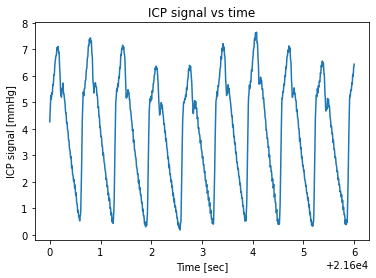

In [4]:
# Plot ICP signal
plt.plot(spantime[indices], ICP_signal[indices])
plt.xlabel('Time [sec]')
plt.ylabel('ICP signal [mmHg]')
plt.title('ICP signal vs time')

Text(0.5, 1.0, 'ABP signal vs time')

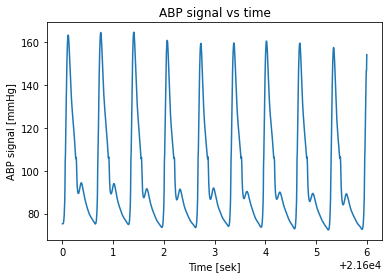

In [5]:
# Plot ABP signal
plt.plot(spantime[indices], ABP_signal[indices])
plt.xlabel('Time [sek]')
plt.ylabel('ABP signal [mmHg]')
plt.title('ABP signal vs time')

### Create a signal with visual difference between peaks

In [6]:
n = len(indices)
irr_signal_ICP = np.zeros(int(n/4+n/2.)+1)
irr_signal_ABP = np.zeros(int(n/4+n/2.)+1)
irr_spantime = np.arange(len(irr_signal_ICP))/fs

counter = 0
for i in range(0, int(n/2.), 2):
    irr_signal_ICP[counter] = (ICP_signal[indices][i]+ICP_signal[indices][i])/2
    irr_signal_ABP[counter] = (ABP_signal[indices][i]+ABP_signal[indices][i])/2
    counter += 1

for i in range(int(n/2), n):
    irr_signal_ICP[counter] = ICP_signal[indices][i]
    irr_signal_ABP[counter] = ABP_signal[indices][i]
    counter += 1

Text(0.5, 1.0, 'Irregular ICP signal vs time')

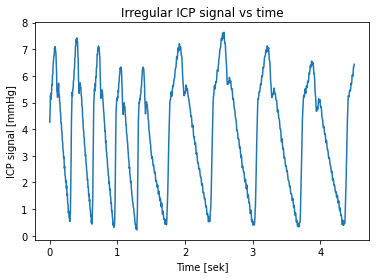

In [7]:
# Plot irregular ICP signal
plt.plot(irr_spantime, irr_signal_ICP)
plt.xlabel('Time [sek]')
plt.ylabel('ICP signal [mmHg]')
plt.title('Irregular ICP signal vs time')

Text(0.5, 1.0, 'Irregular ABP signal vs time')

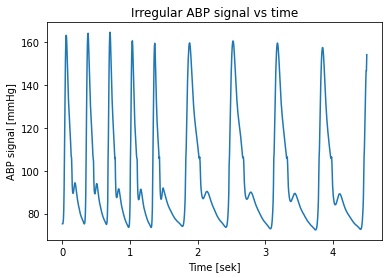

In [8]:
# Plot irregular ABP signal
plt.plot(irr_spantime, irr_signal_ABP)
plt.xlabel('Time [sek]')
plt.ylabel('ABP signal [mmHg]')
plt.title('Irregular ABP signal vs time')

### Illustrating findind the peaks with and without scaling the estimated wavelength
We have found that downscaling the estimated wavelength given as argument to ```peakdetection4``` increases the number of peaks detected.

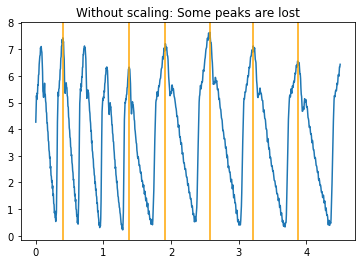

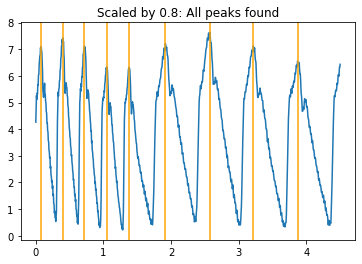

In [9]:
peak_ICP, idx_peak_ICP = da.searchpeak(irr_signal_ICP, irr_spantime, fmin=0.5, fmax=2)
guess_ICP = 1/peak_ICP*fs 
peak_arr_ICP = dp.peakdetection4(irr_signal_ICP, guess_ICP)[0]
scale_factor = 0.8
peak_arr_ICP_scaled = dp.peakdetection4(irr_signal_ICP, guess_ICP*scale_factor)[0]

plt.plot(irr_spantime, irr_signal_ICP)
plt.title(f'Without scaling: Some peaks are lost')
for p in irr_spantime[peak_arr_ICP]:
    plt.axvline(x=p, color='orange')
plt.show()

plt.plot(irr_spantime, irr_signal_ICP)
plt.title(f'Scaled by {scale_factor}: All peaks found')
for p in irr_spantime[peak_arr_ICP_scaled]:
    plt.axvline(x=p, color='orange')
plt.show()

## The super_normalizer-function
Below is a demonstration of the super_normalizer-function. 
We want to normalize the irregular ICP signal. 
For illustration we will normalize two additional signals, the irregular ABP signal, and a the sum of the irregular ABP and ICP signal.

Text(0, 0.5, 'Signal')

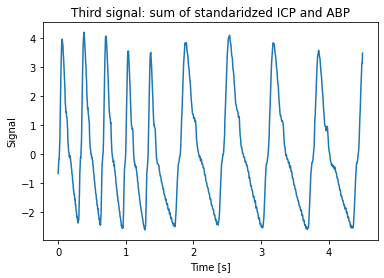

In [10]:
# Creating a third signal
irr_combo_signal = pp.standardize(irr_signal_ICP) + pp.standardize(irr_signal_ABP)
plt.plot(irr_spantime, irr_combo_signal)
plt.title("Third signal: sum of standaridzed ICP and ABP")
plt.xlabel("Time [s]")
plt.ylabel("Signal")

In [11]:
# Putting the three signal in a matrix.
signals = np.zeros((len(irr_spantime), 3))
signals[:,0] = irr_signal_ICP
signals[:,1] = irr_signal_ABP
signals[:,2] = irr_combo_signal

In [12]:
# Calling the supernormalizer function.
normalized_data = sn.supernormalizer(irr_spantime, signals, 0.8, 200, 50)
normalized_time = normalized_data[:,0]
virtual_time = normalized_data[:,1]
normalized_ICP = normalized_data[:,2]
normalized_ABP = normalized_data[:,3]
normalized_combo = normalized_data[:,4]

# Standarize the signals.
normalized_ICP = pp.standardize(normalized_ICP)
normalized_ABP = pp.standardize(normalized_ABP)
normalized_combo = pp.standardize(normalized_combo)

Comments: 
We give the super_normailzer the signals as a matrix where each column is a numpy array corresponding to a signal. 
The first signal is the main signal we want to super normalize. 
The other two signal is normalized with the same shift as the first signal. 
The super_normalizer return a matrix. 
The first two column are the normalized time and the virtual time. 
The normalized time is just a vector of timepoint sampled at the points in the normalized signal. 
The virtual time is a vector where each wavelength takes one second, and the tops of the signal corresponds to each whole second.
The final three columns return are the normalized main signal, and the two other signal super normalized w.r.t to the main signal. 

Text(0, 0.5, 'Standardized signal')

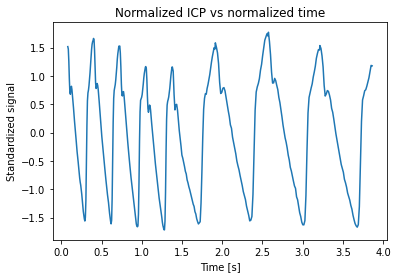

In [13]:
plt.plot(normalized_time, normalized_ICP)
plt.title("Normalized ICP vs normalized time")
plt.xlabel("Time [s]")
plt.ylabel("Standardized signal")

In [14]:
plt.plot(virtual_time, normalized_ICP)
plt.title("Normalized ICP vs virtual time")
plt.xlabel("Time [s]")
plt.ylabel("Standardized signal")
plt.show()

In [15]:
irr_signal_ICP_standardized = pp.standardize(irr_signal_ICP)
plt.plot(irr_spantime, irr_signal_ICP_standardized, '+')
plt.plot(normalized_time, normalized_ICP, '+')
plt.title("Illustration of resampled signal points and original signal points")
plt.xlabel("Time [s]")
plt.ylabel("Standardized signal")

Text(0, 0.5, 'Standardized signal')

Comment: 
Here we see the original signal points alongside the super normalized signal points. 
Each top has the same number of orange points. 

In [16]:
plt.plot(virtual_time, normalized_ICP)
plt.plot(virtual_time, normalized_ABP)
plt.plot(virtual_time, normalized_combo)
plt.title("Standaridized ICP and combo signal vs virtual time")
plt.xlabel("Virtual time [s]")
plt.ylabel("Standardized signal")
plt.legend(["ICP", "ABP", "Combo signal"])

Above we see that all three signal aligns. 

The normalized ICP has wavelength of 1 unit, and the two other signals are scaled to be aligned to the ICP.